In [1]:
# jupyter nbconvert HW8.ipynb --TagRemovePreprocessor.remove_cell_tags='{"remove-cell"}' --to pdf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from qpsolvers import solve_qp
from scipy.optimize import minimize

%matplotlib inline
%config InlineBackend.figure_format = 'png'

from pylab import rcParams
rcParams.update({"axes.grid" : True})
rcParams['figure.figsize'] = (6,4)
rcParams['lines.linewidth'] = 1
rcParams['image.cmap'] = 'Greys'
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['font.weight'] = 400
rcParams['font.size'] = 9
rcParams['xtick.color'] = '#111111'
rcParams['ytick.color'] = '#111111'
rcParams['grid.color'] = '#dddddd'
rcParams['grid.linestyle'] = '-'
rcParams['grid.linewidth'] = 0.5
rcParams['axes.titlesize'] = 12
rcParams['axes.titleweight'] = 500
rcParams['axes.labelsize'] = 10
rcParams['axes.labelweight'] = 400
rcParams['axes.linewidth'] = 0.5
rcParams['axes.edgecolor'] = [.25,.25,.25]

# About HW8

In this HW, we will code both the primal and dual form of SVM and utilize a general quadratic programming (`quadprog` package) solve to help us obtain the solution. 

# Question 1 [50 Points] Sovling SVM using Quadratic Programming

Install the `quadprog` package. The same package is also available in Python. However, make sure to read their documentations carefully. We will utilize the function `solve.QP` to solve SVM. This function is trying to perform the minimization problem:
$$
\text{minimize} \frac{1}{2} b^T \mathbf{D} b - d^T b, \nonumber \\
\text{subject to} \mathbf{A}^T b \geq b_0, \nonumber
$$
where $b$ is the unknown parameter. For more details, read the documentation of the \texttt{quadprog} package on CRAN. Use our the provided training data. This is a linearly separable problem. 

I load in the data below:

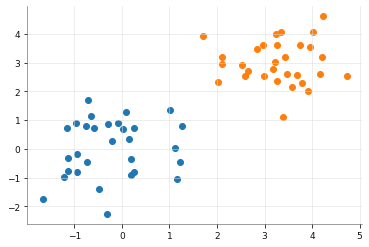

In [2]:
train = np.array(pd.read_csv('./data/SVM-Q1.csv'))
x = train[:,0:2]
y = train[:,2]
n = np.shape(x)[0]
p = np.shape(x)[0]
plt.scatter(x[y==1,0], x[y==1,1])
plt.scatter(x[y==-1,0], x[y==-1,1])
plt.show()

## a) [25 points] The Primal Form

Use the formulation defined on page 13 of the `SVM` lecture note. The primal problem is 

$$
\begin{aligned}
\quad \underset{\beta_{0}, \boldsymbol{\beta}}{\text{minimize}} &\quad  \frac{1}{2} \|\boldsymbol{\beta}\|^{2} \\
\text{subject to} &\quad y_{i}\left(x_{i}^{\top} \boldsymbol{\beta}+\beta_{0}\right) \geq 1, \,\, \text{for} \,\, i=1, \ldots, n
\end{aligned}
$$

Perform the following:

  * Let $b = (\beta_0, \boldsymbol \beta)$ in the `solve.QP()` function. Properly define $\mathbf{D}$, $d$, $\mathbf{A}$ and $b_0$ corresponding to this $b$ for the linearly separable SVM primal problem.
  * Calculate the decision function by solving this optimization problem with the `solve.QP()` function.
  * Report our $\beta_0$ and $\boldsymbol \beta$
  * Plot the decision line on top the previous training data scatter plot. Include the two margin lines. Clearly mark the support vectors. 

__Note__: The package requires $\mathbf{D}$ to be positive definite, while it is not true in our case. To address this problem, __add $10^{-10}$ to the top-left element__ of your $\mathbf{D}$ matrix, which is the one corresponding to $\beta_0$. This will make $\mathbf{D}$ invertible. This may affect your results slightly. So be careful when plotting your support vectors. 

In [3]:
P = np.diag((1e-10,1,1)).astype('double')
q = np.array([0,0,0]).astype('double')
h = -1 * np.ones(n).astype('double')
G = np.vstack((-1*y,-1*y*x[:,0],-1*y*x[:,1])).T.astype('double')

beta_and_b0 = solve_qp(P=P, q=q, h=h, G=G)
b0_primal = beta_and_b0[0]
beta_primal = beta_and_b0[1:]

Beta 0: 3.419238439968422
Beta 1 and 2: [-1.0457306  -0.99907938]


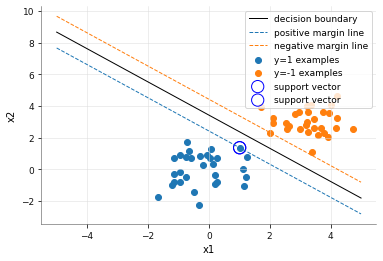

In [4]:
print(f'Beta 0: {b0_primal}')
print(f'Beta 1 and 2: {beta_primal}')

a = -beta_primal[0] / beta_primal[1]
xx = np.linspace(-5, 5)
yy = a * xx - (b0_primal) / beta_primal[1]

plt.scatter(x[y==1,0], x[y==1,1], label='y=1 examples')
plt.scatter(x[y==-1,0], x[y==-1,1], label='y=-1 examples')
plt.plot(xx, yy, 'k-', label='decision boundary')

sv_pos = x[y==1,:][np.argmin(x[y==1,:]@beta_primal)]
sv_neg = x[y==-1,:][np.argmax(x[y==-1,:]@beta_primal)]
svs = np.array(sv_pos.tolist()+sv_neg.tolist())

b_pos = sv_pos[1] - a * sv_pos[0]
b_neg = sv_neg[1] - a * sv_neg[0]

yy_pos = a * xx + b_pos
yy_neg = a * xx + b_neg
plt.plot(xx, yy_pos, '--', label='positive margin line')
plt.plot(xx, yy_neg, '--', label='negative margin line')
plt.scatter(svs[0],svs[1],s=150, label='support vector', marker='o',facecolors='none', edgecolors='b')
plt.scatter(svs[0],svs[1],s=150, label='support vector',facecolors='none', edgecolors='b')
plt.legend(loc='upper right')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

## b) [25 points] The Dual Form

Formulate the SVM __dual__ problem on page 21 the lecture note. The dual problem is 

$$
\begin{aligned}
\underset{\boldsymbol \alpha}{\text{maximize}} & \quad \sum_{i=1}^{n} \alpha_{i}-\frac{1}{2} \sum_{i, j=1}^{n} y_{i} y_{j} \alpha_{i} \alpha_{j} x_{i}^{\top} x_{j} \\
\text{subject to} & \quad \alpha_{i} \geq 0, \,\, \text{for} \,\, i=1, \ldots, n \\
\text{and} & \quad \sum_{i=1}^{n} \alpha_{i} y_{i}=0
\end{aligned}
$$

Perform the following:

  * Let $b = (\alpha_1, \ldots, \alpha_n)^T$. Then properly define $\mathbf{D}$, $d$, $\mathbf{A}$ and $b_0$ corresponding to this $b$ for our SVM problem.
  * Note: Equality constrains can be addressed using the `meq` argument.
  * Obtain the solution using the `solve.QP()` function, and convert the solution into $\boldsymbol \beta$ and $\beta_0$. 
  
You need to report
  * A table including $\beta_0, \beta_1, \beta_2)$ of both Q1a and Q1b. Only keep first three digits after the decimal point.
  * Plot the decision line on top of our scatter plot. Include the two margin lines. Clearly mark the support vectors. 
  * Report the $\ell_1$ norm of $\beta_{Q1a} - \beta_{Q1b}$, where $\beta_{Q1a}$ and $\beta_{Q2b}$ are the 3-dimensional solution obtained in Q1a and Q1b, respectively.

__Note__: Again, $\mathbf{D}$ may not be positive definite. This time, add $10^{-10}$ to all diagonal elements to $\mathbf{D}$. This may affect your results slightly. So be careful when plotting your support vectors. 


In [5]:
#Initializing values and computing H. Note the 1. to force to float type
H = np.dot(y.reshape((-1,1))*x, (y.reshape((-1,1))*x).T)
q = -1*np.ones(n)
G = -1*np.diag(np.ones(n))
h = np.zeros(n)
A = y.reshape(1,-1)
b = np.zeros(1)

for i in range(n):
    H[i,i] = H[i,i]+1e-10
#Run solver
alphas = solve_qp(H, q, G, h, A, b)
beta_dual = ((y * alphas).T @ x)
b0_dual = -(np.max(x[y==-1,:]@beta_dual) + np.min(x[y==1,:]@beta_dual))/2

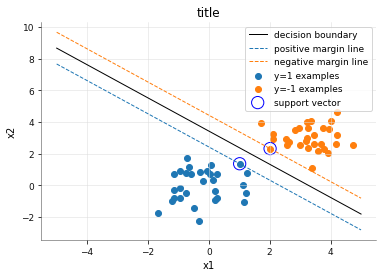

,0,1,2
Betas primal,3.419,-1.046,-0.999
Betas dual,3.420,-1.046,-0.999


L1 norm between primal and dual betas: 0.0005407776270179854


In [6]:
svs = x[alphas>1e-4]

a = -beta_dual[0] / beta_dual[1]
xx = np.linspace(-5, 5)
yy = a * xx - (b0_primal) / beta_dual[1]

plt.scatter(x[y==1,0], x[y==1,1], label='y=1 examples')
plt.scatter(x[y==-1,0], x[y==-1,1], label='y=-1 examples')
plt.plot(xx, yy, 'k-', label='decision boundary')

sv_pos = x[y==1,:][np.argmin(x[y==1,:]@beta_dual)]
sv_neg = x[y==-1,:][np.argmax(x[y==-1,:]@beta_dual)]

b_pos = sv_pos[1] - a * sv_pos[0]
b_neg = sv_neg[1] - a * sv_neg[0]

yy_pos = a * xx + b_pos
yy_neg = a * xx + b_neg
plt.plot(xx, yy_pos, '--', label='positive margin line')
plt.plot(xx, yy_neg, '--', label='negative margin line')
# plt.scatter(sv_pos[0],sv_pos[1],s=150, label='positive (y=1) support vector', marker='o',facecolors='none', edgecolors='b')
# plt.scatter(sv_neg[0],sv_neg[1],s=150, label='negative (y=-1) support vector',facecolors='none', edgecolors='orange')

plt.title('title')
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(svs[:,0], svs[:,1], s=150, label='support vector', marker='o',facecolors='none', edgecolors='b')
#plt.scatter(svs_neg[:,0], svs_neg[:,1], s=150, label='negative (y=-1) support vector', marker='o',facecolors='none', edgecolors='orange')
plt.legend(loc='upper right')
plt.show()

all_primal_betas = [b0_primal]+beta_primal.tolist()
all_dual_betas = [b0_dual]+beta_dual.tolist()

all_primal_betas_formatted = [format(beta, ".3f") for beta in all_primal_betas]
all_dual_betas_formatted = [format(beta, ".3f") for beta in all_dual_betas]
dict = {
        'Betas primal' : all_primal_betas_formatted,
        'Betas dual' : all_dual_betas_formatted,
       }
df = pd.DataFrame(dict)
display(df.T)
l1_norm = np.abs(np.array(all_primal_betas)-np.array(all_dual_betas)).sum()
print(f'L1 norm between primal and dual betas: {l1_norm}')

# Question 2 [20 Points] Linearly nonseparable SVM

In this question, we will follow the formulation in Page 30 to solve a linearly nonseparable SVM. The dual problem is given by 

$$
\begin{aligned}
\underset{\boldsymbol \alpha}{\text{maximize}} & \quad \sum_{i=1}^{n} \alpha_{i}-\frac{1}{2} \sum_{i, j=1}^{n} y_{i} y_{j} \alpha_{i} \alpha_{j} x_{i}^{\top} x_{j} \\
\text{subject to} & \quad 0 \leq \alpha_{i} \leq C, \,\, \text{for} \,\, i=1, \ldots, n \\
\text{and} & \quad \sum_{i=1}^{n} \alpha_{i} y_{i}=0
\end{aligned}
$$

Perform the following:

  * Let $b = (\alpha_1, \ldots, \alpha_n)^T$. Then properly define $\mathbf{D}$, $d$, $\mathbf{A}$ and $b_0$ corresponding to this $b$ for this problem. Use $C = 1$ as the penalty team. 
  * Note: Equality constrains can be addressed using the `meq` argument.
  * Obtain the solution using the `solve.QP()` function, and convert the solution into $\boldsymbol \beta$ and $\beta_0$. Note: 
    + use the information provided on page 32 to obtain the support vectors and $\beta_0$. 
    + Your solution may encounter numerical errors, e.g., very small negative $\alpha$ values, or values very close to $C$. You could consider thresholding them to exactly 0 or $C$
    + Your $\mathbf{D}$ may not be definite positive, so consider adding $10^{-10}$ to its diagonal elements. 

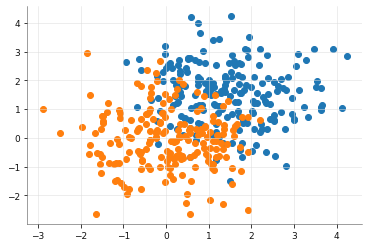

In [7]:
train = np.array(pd.read_csv('./data/SVM-Q2.csv'))
x = train[:,0:2]
y = train[:,2]
n = np.shape(x)[0]
p = np.shape(x)[0]
plt.scatter(x[y==1,0], x[y==1,1])
plt.scatter(x[y==-1,0], x[y==-1,1])
plt.show()

In [8]:
#Initializing values and computing H. Note the 1. to force to float type
H = np.dot(y.reshape((-1,1))*x, (y.reshape((-1,1))*x).T)*1.
q = -1*np.ones(n)*1.
lb = np.zeros(n)*1.
ub = np.ones(n)*1.
A = y.reshape(1,-1)*1.
b = np.zeros(1)*1.

for i in range(n):
    H[i,i] = H[i,i]+1e-10
#Run solver
non_sep_dual_alphas = solve_qp(P=H, q=q, A=A, b=b, lb=lb, ub=ub)
non_sep_dual_alphas = non_sep_dual_alphas.clip(0.0,1.0)

In [9]:
def missclassification(x, betas, y_true):
    x_with_ones = np.hstack( (np.ones(x.shape[0]).reshape(-1,1), x) )
    pred = x_with_ones@betas
    pred = np.where(pred >0, 1, -1)
    return np.mean(pred != y_true)

beta 1 and 2 =  [1.15205219 1.11165171]
b0 =  -1.3845806593328565
Misclassification rate: 0.1525


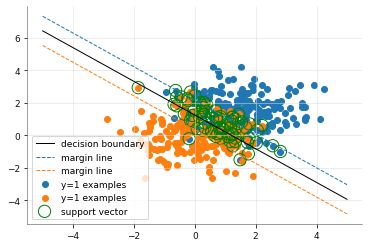

In [10]:
w = ((y * non_sep_dual_alphas).T @ x).reshape(-1,1)
S = ((non_sep_dual_alphas > 1e-4) & (non_sep_dual_alphas < 1.0))
b = y[S] - np.dot(x[S], w)


b=-1*((np.max(x[S,:][y[S]==-1]@w) + np.min(x[S,:][y[S]==1]@w))/2)

print('beta 1 and 2 = ', w.flatten())
print('b0 = ', b)
print(f'Misclassification rate: {missclassification(x, np.array([b,w.flatten()[0], w.flatten()[1]]), y)}')

a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (b) / w[1]

# plt.scatter(x[y==1,0], x[y==1,1], label='y=1 examples')
# plt.scatter(x[y==-1,0], x[y==-1,1], label='y=-1 examples')
plt.plot(xx, yy, 'k-', label='decision boundary')
plt.scatter(x[y==1,0], x[y==1,1], label='y=1 examples')
plt.scatter(x[y==-1,0], x[y==-1,1], label='y=1 examples')

sv_x = x[S]
sv_y = y[S]
plt.scatter(sv_x[:,0], sv_x[:,1], s=150, label='support vector', marker='o',facecolors='none', edgecolors='g')


intercept = -(b-1)/w[1]
slope = -w[0]/w[1]
yy1 = slope * xx + intercept

intercept = -(b+1)/w[1]
yy2 = slope * xx + intercept
plt.plot(xx,yy1, '--', label='margin line')
plt.plot(xx,yy2,'--', label='margin line')

plt.legend()
plt.show()

# Question 3 [30 Points] Penalized Loss Linear SVM

We can also perform linear and nonlinear classification using the penalized loss framework. In this question, we will only use the linear version. Use the same dataset in Question 2. Consider the following logistic loss function:

$$L(y, f(x)) = \log(1 + e^{- y f(x)}).$$
The rest of the job is to solve this optimization problem if given the functional form of $f(x)$. To do this, we will utilize the general-purpose optimization package/function. For example, in `R`, you can use the `optim()` function. Read the documentation of this function (or equivalent ones in Python) and set up the objective function properly to solve for the parameters. If you need an example of how to use the `optim()` function, read the corresponding part in the example file provided on our course website [here](https://teazrq.github.io/stat542/other/r-intro.html) (Section 10).

We let $f(x)$ is to be a linear function, SVM can be solved by optimizing a penalized loss:
$$ \underset{\beta_0, \boldsymbol\beta}{\arg\min} \quad \sum_{i=1}^n L(y_i, \beta_0 + x_i^T \boldsymbol\beta) + \lambda \lVert \beta \rVert^2$$
You should use the data from Question 2, and answer these questions:
  
  * [10 pts] Drive the gradient of this penalized loss function, typeset with LaTex. 
  * [10 pts] Write a  penalized loss objective function `SVMfn(b, x, y, lambda)` and its gradient `SVMgn(b, x, y, lambda)`.   
  * [10 pts] Solve the coefficients using `optim()` and your objective and gradient functions with $\lambda = 1$ and `BFGS` method. Use 0 as the initialized value. 
  
Report the followings:

  * Your coefficients
  * Your loss and mis-classification rate on training data.
  * Plot all data and the decision line
  * Hint: If you want to check your gradient function, you can run `optim()` without a this gradient function and compare the parameters to your previous ones. Note this will be much slower. You are not required to report this result. 


Gradient Derivation:
$$
\begin{aligned}
G(x) = \sum_{i=1}^n log(1+e^{-y_{i}(\beta_{0} + x_{i}^{T}\beta)}) + \lambda \beta^{T} \beta \\
\frac{\delta G}{\delta \beta_{0}} = \sum_{i=1}^n \frac{-y_i}{1+e^{-y_{i}(\beta_{0} + x_{i}^{T}\beta)}} \\
\frac{\delta G}{\delta \beta} = \sum_{i=1}^n \frac{-y_ix_{i}}{1+e^{-y_{i}(\beta_{0} + x_{i}^{T}\beta)}} + 2 \lambda \beta
\end{aligned}
$$

In [11]:
def logistic(x):
    return (np.log(1 + np.exp(-x)))


def SVMfn(b, x, y, lam):
    res = 0
    
    for i in range(x.shape[0]):
        res = res + logistic(y[i]*x[i,:]@b)
    
    res = res + lam*np.sum(b*b)
    return res


def SVMgn(b, x, y, lam):
    res = np.array([0.,0.,0.])
    for i in range(x.shape[0]):
        denom = 1 + np.exp(y[i]*x[i,:]@b)
        num1 = -y[i]
        res[0] = res[0] + num1/denom
        num2 = -y[i]*x[i,1:3]
        res[1:3] = res[1:3] + num2/denom
    
    res[1:3] = res[1:3] + 2*lam*b[1:3]
    return res

def SVMfnAndgn(b,x,y,lam):
    return (SVMfn(b,x,y,lam), SVMgn(b,x,y,lam))

Beta 0: -2.262448679021386
Beta 1 and 2: [1.57150924 1.5041386 ]
Loss: 134.9817055914514
Misclassification rate: 0.1475


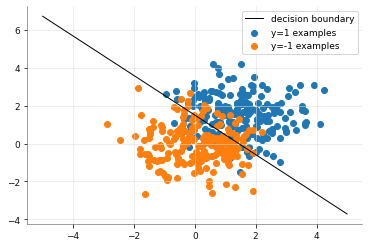

In [12]:
x_with_ones = np.hstack( (np.ones(x.shape[0]).reshape(-1,1), x) )
minimization_results = minimize(SVMfnAndgn, np.array([0.,0.,0.]), args=(x_with_ones, y, 1), method='L-BFGS-B', jac=True)
a = -minimization_results.x[1] / minimization_results.x[2]
xx = np.linspace(-5, 5)
yy = a * xx - (minimization_results.x[0]) / minimization_results.x[2]

print(f'Beta 0: {minimization_results.x[0]}')
print(f'Beta 1 and 2: {minimization_results.x[1:]}')
print(f'Loss: {minimization_results.fun}')
print(f'Misclassification rate: {missclassification(x, np.array([minimization_results.x[0],minimization_results.x[1], minimization_results.x[2]]), y)}')

plt.scatter(x[y==1,0], x[y==1,1], label='y=1 examples')
plt.scatter(x[y==-1,0], x[y==-1,1], label='y=-1 examples')
plt.plot(xx, yy, 'k-', label='decision boundary')
plt.legend()
plt.show()